This notebook plots the sample completeness functions and redshift distributions as a function of limiting magnitude

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

from lbg_survey_metrics.utils import cache_pz_stat
from lbg_survey_metrics.constants import single_col, double_col, cmaps, colors
from lbg_survey_metrics.galaxy_distribution import redshift_distribution
from lbg_survey_metrics.metrics import get_m5_ranges
import rubin_sim.maf as maf

In [2]:
# Load m5 maps
u5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_u.npz").metric_values
g5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_g.npz").metric_values
r5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_r.npz").metric_values
i5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_i.npz").metric_values
z5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_z.npz").metric_values
y5 = maf.MetricBundle.load("data/rubin_sim_m5/internal_u_expt38_nscale1_1v3_4_10yrs_ExgalM5_y.npz").metric_values

# Get ranges for detection bands
m5_ranges = {}
m5_ranges["u"] = get_m5_ranges(u5, r5)
m5_ranges["g"] = get_m5_ranges(g5, i5)
m5_ranges["r"] = get_m5_ranges(r5, z5, cut_on_drop=False)
m5_ranges["i"] = get_m5_ranges(i5, y5, cut_on_drop=False)
m5_ranges["z"] = get_m5_ranges(z5, y5, cut_on_drop=False)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes
Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


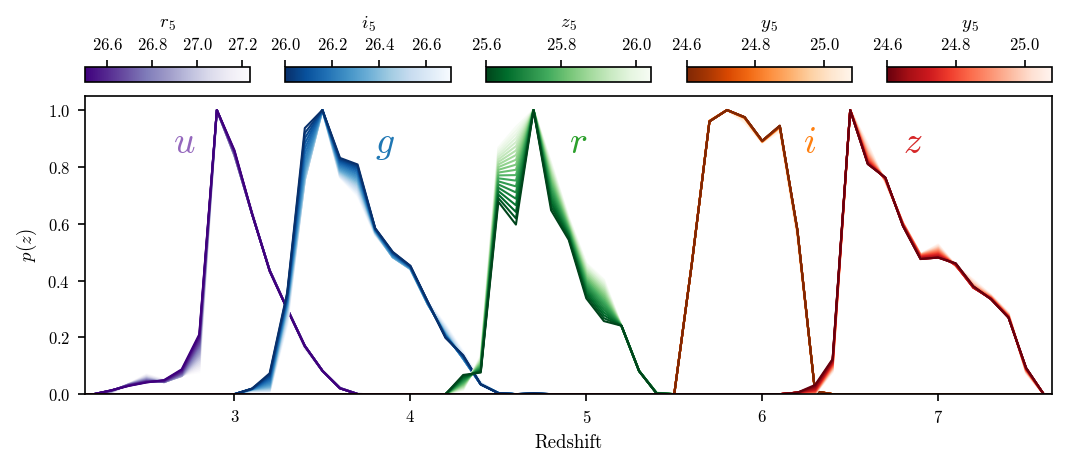

In [3]:
fig, ax = plt.subplots(figsize=double_col, constrained_layout=True, dpi=150)

# Set axis properties
ax.set(
    xlim=(2.15, 7.65),
    ylim=(0, 1.05),
    xlabel="Redshift",
    ylabel="$p(z)$"
)

# Determine colorbar positions
N = 5
xmin, xmax = ax.get_xlim()
sep = 0.2
wid = ((xmax - xmin) - (N-1) * sep) / N
xstart = [i * (wid + sep) + xmin for i in range(N)]
cbar_pos = [
    [xs, 1.1, wid, 0.05]
    for xs in xstart
]

for i, (drop_band, det_band) in enumerate(zip("ugriz", "rizyy")):
    # Get redshift distributions for range of limiting magnitudes
    m5 = np.linspace(
        np.floor(m5_ranges[drop_band]["det_min"] * 10) / 10, 
        m5_ranges[drop_band]["det_max"], 
        20,
    )
    z, pz = redshift_distribution(m5, drop_band, m5_ranges[drop_band]["det_cut"])

    # create LineCollection
    segments = [np.column_stack([z, p / p.max()]) for p in pz]
    lc = LineCollection(segments[::-1], array=m5[::-1], cmap=cmaps[drop_band]+"_r", lw=1)
    ax.add_collection(lc)
    
    s = np.array(segments).T
    mz = np.trapz(s[0] * s[1], s[0], axis=0) / np.trapz(s[1], s[0], axis=0)
    dmz = mz - mz.mean()

    cax = ax.inset_axes(cbar_pos[i], transform=ax.transData)
    cb = fig.colorbar(lc, shrink=0.2, cax=cax, orientation="horizontal", label=f"${det_band}$"+"$_5$")
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_label_position("top")
    cb.ax.set_xticks(np.arange(24, 28, 0.2))
    cb.ax.set_xlim(m5.min(), m5.max())

# Plot band labels
plt.text(2.65, 0.85, "$u$", fontsize=18, color=colors["u"])
plt.text(3.8, 0.85, "$g$", fontsize=18, color=colors["g"])
plt.text(4.9, 0.85, "$r$", fontsize=18, color=colors["r"])
plt.text(6.23, 0.85, "$i$", fontsize=18, color=colors["i"])
plt.text(6.8, 0.85, "$z$", fontsize=18, color=colors["z"])

fig.savefig("../figures/redshift_distribution.pdf")

In [4]:
m5 = np.linspace(24, 28, 100)
mu = {}
sig = {}
for i, band in enumerate("ugriz"):
    # Get redshift distributions for range of limiting magnitudes
    z, pz = redshift_distribution(m5, band)

    mu[band] = np.trapz(z * pz, z, axis=-1)

    std = np.sqrt(np.trapz((z[None, :] - mu[band][:, None]) ** 2 * pz, z, axis=-1))
    sig[band] = std / (1 + mu[band])

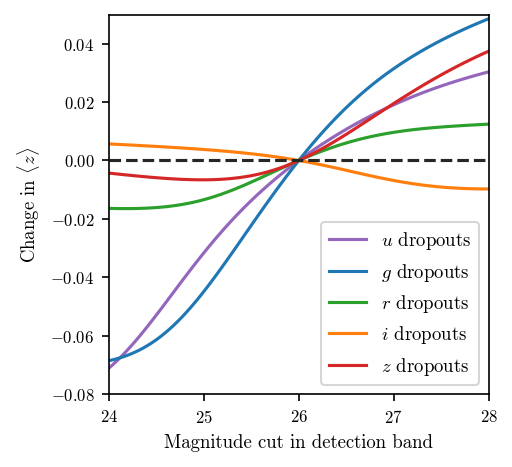

In [5]:
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

for band in "ugriz":
    # Get values from the dict
    mean = mu[band]

    # Normalize at m=26
    norm_mean = np.interp(26, m5, mean)

    # Plot variation in mean
    ax.plot(m5, mean - norm_mean, c=colors[band], label=f"${band}$ dropouts")

ax.legend()
ax.set(
    xlim=(24, 28),
    ylim=(-0.08, 0.05),
    xlabel="Magnitude cut in detection band",
    ylabel=r"Change in $\langle z \rangle$",
)
ax.axhline(0, ls="--", c=colors["black"])

fig.savefig("../figures/pz_mean.pdf")

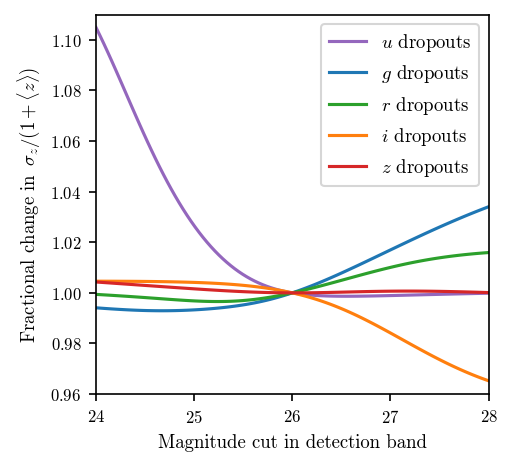

In [6]:
fig, ax = plt.subplots(figsize=single_col, constrained_layout=True, dpi=150)

for band in "ugriz":
    # Get values from the dict
    std = sig[band]

    # Normalize at m=26
    norm_std = np.interp(26, m5, std)

    # Plot variation in width
    ax.plot(m5, std / norm_std, c=colors[band], label=f"${band}$ dropouts")

ax.legend()
ax.set(
    xlim=(24, 28),
    ylim=(0.96, 1.11),
    xlabel="Magnitude cut in detection band",
    ylabel=r"Fractional change in $\, \sigma_z / (1 + \langle z \rangle)$",
)

fig.savefig("../figures/pz_sig.pdf")